### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))

saveDir <- "environment/Chimp/DE"
load(file.path(saveDir, "tseChimp.RData"))
load(file.path(saveDir, "yAll.RData"))
load(file.path(saveDir, "y.RData"))
load(file.path(saveDir, "yg.RData"))
treeCons <- rowTree(tseChimp)
nleaves <- length(treeCons$tip)

# metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
# quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
# samples <- metaData$RUN
# files <- file.path(quantDir, samples, "quant.sf")
# colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
# seMuscle <- tximeta::tximeta(colData)

In [2]:
treeCons <- rowTree(yAll)
nleaves <- length(treeCons$tip)

#### Transcript level analysis

In [3]:
sum(mcols(y)[["keep"]])
sum(mcols(yAll)[["keep"]])
sum(mcols(y)[["pvalue"]] < 0.1, na.rm=T)
sum(mcols(yAll)[treeCons$tip.label,"pvalue"] < 0.1, na.rm=T)

sum(mcols(y)[["qvalue"]] < 0.1, na.rm=T)
sum(mcols(yAll)[treeCons$tip.label,"qvalue"] < 0.1, na.rm=T)

[1] 25236

[1] 49951

[1] 13831

[1] 13496

[1] 11886

[1] 11813

##### Differentially Expressed Transcripts

In [4]:
sapply(c(0.01,0.05,0.1), function(x) sum(mcols(y)[["qvalue"]] <= x, na.rm=T))
dTxps <- lapply(c(0.01,0.05,0.1), function(x) rownames(y)[which(mcols(y)[["qvalue"]] <= x)])

[1]  3539 10133 11886

##### Genes Mapping to those transcripts

In [5]:
mapDf <- rowData(tseChimp)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "GENEID"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 3236 8304 9492

#### Gene Level

##### Differentially expressed genes

In [6]:
dges <- lapply(c(0.01,0.05,0.1), function(x) rownames(yg)[which(mcols(yg)[["qvalue"]] <= x)])
sapply(dges, length)

[1] 6090 8256 9354

### Genes that are considered differentially expressed in gene level analysis but don't contain a single differentially expressed transcript

In [7]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## dges that are mapped by genes but not by differential transcripts
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Genes that are mapped to differential transcripts but not mapped by genes
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 2984  787  716

[1] 130 835 854

#### TreeDE, with the total number of nodes, inner nodes and their height distribution

In [8]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
treeDE <- treeDEFDR_OL[["mIRV=0.4"]] ## renaming the treeDE variable
sapply(treeDE, length) ## number of differentially expressed nodes
sapply(treeDE, function(nodes) sum(nodes > nleaves)) ## number of inner nodes
lapply(treeDE, function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights

[1]  4001 10247 12017

[1] 1280 2268 2745

[[1]]

   1    2    3    4    5    6    7    8    9   10 
2721  705  342  126   70   18   10    5    3    1 

[[2]]

   1    2    3    4    5    6    7    8    9 
7979 1387  554  196   73   33   15    6    4 

[[3]]

   1    2    3    4    5    6    7    8    9 
9272 1731  643  229   78   36   18    6    4 


##### Genes mapping to the treeDE nodes and their number

In [9]:
genesTreeDE <- lapply(treeDE, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"GENEID"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3714 8661 9904

[[1]]

   1    2 
3943   58 

[[2]]

    1     2     3 
10106   140     1 

[[3]]

    1     2     3 
11842   174     1 


#### Genes that map only to treeDE but are neither DE or covered by differential transcripts

In [10]:
innerNodesUniqueGenes <- lapply(seq_along(genesTreeDE), function(i) setdiff(unlist(genesTreeDE[[i]]), union(dges[[i]], txpGenes[[i]])))
head(innerNodesUniqueGenes[[2]]) 
sapply(innerNodesUniqueGenes, length)

[1] "ENSPTRG00000018521" "ENSPTRG00000000910" "ENSPTRG00000019904"
[4] "ENSPTRG00000050773" "ENSPTRG00000019837" "ENSPTRG00000043336"

[1]  74 165 199

In [11]:
unGenesSNode <- lapply(seq_along(innerNodesUniqueGenes), function(i) {
        gNodes <- innerNodesUniqueGenes[[i]]
        gNodes[sapply(gNodes, function(gene) {
    sum(sapply(genesTreeDE[[i]], function(g) sum(gene %in% g) > 0 & length(g)>1)) == 0 ##gene maps unique to a single node
})]
})
# innerNodesUniqueGenes[[2]][sapply(innerNodesUniqueGenes[[2]], function(gene) {
#     sum(sapply(genesTreeDE[[2]], function(g) sum(gene %in% g) > 0 & length(g)>1)) == 0
# })]

In [13]:
sapply(unGenesSNode, length) ### Nodes that map to a single gene

[1] 21 27 44

Such inner nodes can be possible DTUs. We thus extract the treeDE nodes to which these genes map to and try to see if there are multiple such tree DE nodes that map to same gene.Looking at the 0.05 threshold change, we find only 0 gene for which a dtu on the inner nodes is observed.

For the remaining that have map to inner node, infRV decreases compared to their children though the logFC is lower compared to children. logFC though definitely decreases at gene.

In [15]:
qval <- 0.15
i <- 3
gN <- unGenesSNode[[i]][which(mcols(yg)[unGenesSNode[[i]],"qvalue"] > qval)]
length(gN) ## genes belonging to the unique treeDE nodes that have qvalue > 0.15 when doing gene level DE analysis

# extracting genes unique to treeDE and have logFC > 0.2 or have atleast two sig nodes
twoNodes <- list() 
lfcNodes <- c()
j <- 1
for(g in gN) {
    iid <- which(sapply(genesTreeDE[[i]], function(genes) sum(g %in%  genes) > 0))
    if(length(iid) > 1) {
        twoNodes[[j]] <- iid
        j <- j + 1
    }
    else if(length(which(abs(mcols(yAll)[treeDE[[2]][iid],"log2FC"]) > 0.2)) > 0) {
        lfcNodes <- c(lfcNodes, iid)
    }
}
length(twoNodes)
length(lfcNodes)

[1] 34

[1] 0

[1] 30

##### Other example of the above genes that however show no dtu

In [20]:
head(order(mcols(yAll)[treeDE[[2]][lfcNodes],"qvalue"]), 30)

[1]   7  60 101  17  80  71  43  12  59  42  79  32  74   5  34  63  65  40  45
[20]  51   1  41  91  99  15   4  83  16   8  86

[1] "ENSPTRG00000003756"


In [16]:
tnames <- sapply(strsplit(rownames(y), ".", fixed=T), function(g) g[1])
rnames <- rownames(y)
names(rnames) <- tnames

In [58]:
## A lowering of the LFC but also along with a substantial decrease in infRV
## Some of these nodes map to multiple genes some of which are DEs

### Show 10, 96, 129, 60
j <- 7
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(gy)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
txps <- rnames[unlist(rowData(gy)[gs,"tx_ids"])]
mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

j <- 60
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(gy)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
txps <- rnames[unlist(rowData(gy)[gs,"tx_ids"])]
mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]


j <- 101
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(gy)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
txps <- rnames[unlist(rowData(gy)[gs,"tx_ids"])]
mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

j <- 17
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(gy)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
txps <- rnames[unlist(rowData(gy)[gs,"tx_ids"])]
mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]


# j <- 140
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# print(gs)
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# txps <- intersect(unlist(rowData(yg)[gs,"tx_ids"]), rownames(y))
# mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

# j <- 6
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# print(gs)
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# txps <- intersect(unlist(rowData(yg)[gs,"tx_ids"]), rownames(y))
# mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

# j <- 144
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# print(gs)
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# txps <- intersect(unlist(rowData(yg)[gs,"tx_ids"]), rownames(y))
# mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

# j <- 77
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# print(gs)
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# txps <- intersect(unlist(rowData(yg)[gs,"tx_ids"]), rownames(y))
# mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

# j <- 12
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# print(gs)
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# txps <- intersect(unlist(rowData(yg)[gs,"tx_ids"]), rownames(y))
# mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# treeCons$tip[unlist(Descendants(treeCons, treeDE[[2]][lfcNodes[j]]))]

[1] "ENSPTRG00000017289"


DataFrame with 1 row and 3 columns
                   log10mean    log2FC    qvalue
                   <numeric> <numeric> <numeric>
ENSPTRG00000017289   2.92595  0.200591  0.478691

DataFrame with 1 row and 4 columns
          meanInfRV log10mean    log2FC      qvalue
          <numeric> <numeric> <numeric>   <numeric>
Node47106  0.121311   2.87189  0.430705 1.09745e-06

DataFrame with 3 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000031995.4 19.795755   2.63370 0.3996194  0.194952
ENSPTRT00000077169.1  0.203219   1.66853 0.0648727  0.790782
ENSPTRT00000083497.1 29.756853   2.49691 0.4781580  0.365346

[1] "ENSPTRT00000083497.1" "ENSPTRT00000031995.4"

[1] "ENSPTRG00000015426"


DataFrame with 1 row and 3 columns
                   log10mean    log2FC    qvalue
                   <numeric> <numeric> <numeric>
ENSPTRG00000015426   2.24483 -0.653918   0.22476

DataFrame with 1 row and 4 columns
          meanInfRV log10mean    log2FC      qvalue
          <numeric> <numeric> <numeric>   <numeric>
Node62547 0.0645414   2.42287  -1.34843 1.09745e-06

DataFrame with 3 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000028805.4  28.29357   2.03134 -1.377275  0.067869
ENSPTRT00000097652.1  22.69226   2.19954 -1.247895  0.110589
ENSPTRT00000099869.1   1.11857   1.28221  0.222684  0.707436

[1] "ENSPTRT00000097652.1" "ENSPTRT00000028805.4"

[1] "ENSPTRG00000023677"


DataFrame with 1 row and 3 columns
                   log10mean    log2FC    qvalue
                   <numeric> <numeric> <numeric>
ENSPTRG00000023677   2.43462  0.710787  0.320308

DataFrame with 1 row and 4 columns
          meanInfRV log10mean    log2FC      qvalue
          <numeric> <numeric> <numeric>   <numeric>
Node72091 0.0884303   2.32831  0.678564 1.09745e-06

DataFrame with 3 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000050834.4   3.23270   1.56306  0.618052 0.1808838
ENSPTRT00000082175.1  17.39499   1.48775        NA        NA
ENSPTRT00000107623.1   6.50804   2.15382  0.581682 0.0883205

[1] "ENSPTRT00000107623.1" "ENSPTRT00000082175.1" "ENSPTRT00000050834.4"

[1] "ENSPTRG00000007533"


DataFrame with 1 row and 3 columns
                   log10mean    log2FC    qvalue
                   <numeric> <numeric> <numeric>
ENSPTRG00000007533   2.72469 -0.499219   0.22207

DataFrame with 1 row and 4 columns
          meanInfRV log10mean    log2FC     qvalue
          <numeric> <numeric> <numeric>  <numeric>
Node48252 0.0731386   2.78153 -0.501752 0.00193015

DataFrame with 3 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000013883.5  12.09973   2.30319 -0.889919  0.136598
ENSPTRT00000079623.1  12.86019   2.31672 -0.439393  0.256928
ENSPTRT00000100721.1   8.33453   2.29293 -0.351177  0.201557

[1] "ENSPTRT00000079623.1" "ENSPTRT00000013883.5" "ENSPTRT00000100721.1"

Transcript end side different
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000028936;r=4:152410199-152418528 
Mutually exclusive exon(start)
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000045917;r=4:63477018-63504594
Transcript end side different
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000030678;r=7:126621302-126626209
Different start side
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000058881;r=18:82928788-83023439
Skipped Exon
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000002546;r=2:32177396-32197933

#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [12]:
genesNodeCommonDGE <- lapply(seq_along(diffGenes), function(i) unlist(genesTreeDE[[i]])[unlist(genesTreeDE[[i]]) %in% diffGenes[[i]]]) ## Number of genes mapping to inner nodes that also map to dges but not dtes
                             
#### Extracting the index in geneTreeDE                      
treeDECommonInds <- lapply(seq_along(genesNodeCommonDGE), function(i) {
    sapply(genesNodeCommonDGE[[i]], function(genes) {
        sapply(genes, function(gene) {
            which(sapply(genesTreeDE[[i]], function(gs) sum(gene %in% gs) > 0))
        })
    })
})
sapply(genesNodeCommonDGE, length)

[1] 408 194 215

In [13]:
#### Extracting the gene nodes that are unique aka they map to only 1 gene
#### Note that single gene can map to multiple nodes within treeDE, so we need to remove that at well
treeDECommonInds <- lapply(seq_along(treeDECommonInds), function(i) {
    iList <- treeDECommonInds[[i]]
    inds <- which(sapply(iList, function(iL) {
        length(unique(unlist(genesTreeDE[[i]][iL])))==1
    }))
    iList[names(iList)[inds]]
})
sapply(treeDECommonInds, length)

[1] 375 184 194

In [14]:
head(order(mcols(yg)[names(treeDECommonInds[[3]]), "qvalue"]),30)
names(treeDECommonInds[[3]][18])

[1]  18  23  46  67  73  74  75  76 100 129 130 167 177 183 185  32  83 143 168
[20]  86 194  36  69  71  88  91  78  89 127 148

[1] "ENSPTRG00000018599"

In [53]:
for(j in c(73, 97, 136, 69, 9, 93)) {
        gs <- names(treeDECommonInds[[2]])[j]
        print(gs)
        print(mcols(gy)[gs,c("log10mean", "log2FC", "qvalue")])
        node <- treeDE[[2]][treeDECommonInds[[2]][[j]]]
        print(mcols(yAll)[node,c("meanInfRV", "log10mean", "log2FC", "qvalue")])
        txps <- intersect(rnames[unlist(rowData(gy)[gs,"tx_ids"])], rownames(y))
        print(mcols(y)[txps, c("meanInfRV", "log10mean", "log2FC", "qvalue")])
        print(treeCons$tip[unlist(Descendants(treeCons, node))])
        print("next")
}


[1] "ENSPTRG00000017182"
DataFrame with 1 row and 3 columns
                   log10mean    log2FC      qvalue
                   <numeric> <numeric>   <numeric>
ENSPTRG00000017182   2.74239 -0.511141 4.19463e-06
DataFrame with 2 rows and 4 columns
          meanInfRV log10mean    log2FC     qvalue
          <numeric> <numeric> <numeric>  <numeric>
Node57641   3.68507   2.04386 -0.599623 0.04828378
Node57643   0.36223   2.69548 -0.393650 0.00193015
DataFrame with 6 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000061959.3   7.77064   1.30743        NA        NA
ENSPTRT00000080856.1  25.46061   2.09580 -1.245293 0.0893939
ENSPTRT00000093587.1   8.14137   2.55154 -0.153924 0.3663176
ENSPTRT00000102108.1   6.46997   1.46636 -0.479068 0.4863730
ENSPTRT00000103985.1   5.06890   1.92007 -0.430987 0.3432334
ENSPTRT00000106380.1  11.16375   1.24887        NA        NA
[1] "ENSPTRT00000103985

https://useast.ensembl.org/Pan_troglodytes/Gene/Summary?db=core;g=ENSPTRG00000017182;r=5:123343707-123449338 (missing exons)
https://useast.ensembl.org/Pan_troglodytes/Gene/Summary?db=core;g=ENSPTRG00000008167;r=16:48444105-48488981 (different exons)
https://useast.ensembl.org/Pan_troglodytes/Gene/Summary?db=core;g=ENSPTRG00000011776;r=2A:28200362-28222512 (skipped exons)
https://useast.ensembl.org/Pan_troglodytes/Gene/Summary?db=core;g=ENSPTRG00000008182;r=16:49204939-49210491
(Different exons)
https://useast.ensembl.org/Pan_troglodytes/Gene/Summary?db=core;g=ENSPTRG00000008182;r=16:49204939-49210491
(Skipped exons)

In [15]:
txdb <- GenomicFeatures::makeTxDbFromGFF("/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/Pan_troglodytes.Pan_tro_3.0.104.gtf")
txpChimp <- GenomicFeatures::transcripts(txdb)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



In [20]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(plotgardener))
library(org.Pt.eg.db)

In [17]:
txpChimp <- GenomicFeatures::transcripts(txdb)
txpChimp <- txpChimp %>%
  mutate(tx_id = as.character(tx_id))

txpChimp <- txpChimp %>%
  mutate(gene_id = mapIds(
           txdb, keys=tx_id,
           column="GENEID", keytype="TXID")
         ) %>%
  filter(!is.na(gene_id))

txpChimp <- txpChimp %>%
                filter(tx_name %in% intersect(treeCons$tip, mcols(txpChimp)[["tx_name"]]))

'select()' returned 1:1 mapping between keys and columns



In [21]:
genesChimp <- GenomicFeatures::genes(txdb)
genesChimp
assemb <- assembly(Genome = "panTro3",
                   TxDb = txdb, 
                   OrgDb = org.Pt.eg.db,
                  gene.id.column = "ENSEMBL",
                  BSgenome = "BSgenome.Ptroglodytes.UCSC.panTro3")
rownames(y) <- gsub("\\.+\\d+", "", rownames(y))
levels(colData(y)[["tissue"]]) <- c("cerbellum", "med. dor. nuc.")
levels(colData(yAll)[["tissue"]]) <- c("cerbellum", "med. dor. nuc.")

GRanges object with 33729 ranges and 1 metadata column:
                     seqnames              ranges strand |            gene_id
                        <Rle>           <IRanges>  <Rle> |        <character>
  ENSPTRG00000000001       15   83213252-83230707      + | ENSPTRG00000000001
  ENSPTRG00000000008        1       363597-382915      + | ENSPTRG00000000008
  ENSPTRG00000000009        1       387674-390634      + | ENSPTRG00000000009
  ENSPTRG00000000017        1       465081-474995      + | ENSPTRG00000000017
  ENSPTRG00000000021        1       492706-496231      + | ENSPTRG00000000021
                 ...      ...                 ...    ... .                ...
  ENSPTRG00000054663        5   62671860-62702353      - | ENSPTRG00000054663
  ENSPTRG00000054664       11 134276313-134293085      - | ENSPTRG00000054664
  ENSPTRG00000054665        3 180231259-180425771      + | ENSPTRG00000054665
  ENSPTRG00000054666        5   57552969-57573453      - | ENSPTRG00000054666
  ENSPTR

In [272]:
j <- 23
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000014551" "ENSPTRT00000105582" "ENSPTRT00000108021"
[4] "ENSPTRT00000104230"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000007897"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
16,24001927,24033758,31832,+,ENSPTRG00000007897


ENSPTRG00000007897   ENSPTRG00000007897   ENSPTRG00000007897 
"ENSPTRT00000014551" "ENSPTRT00000104230" "ENSPTRT00000105582" 
  ENSPTRG00000007897 
"ENSPTRT00000108021"

[1] 1

[1] TRUE

In [280]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 5
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



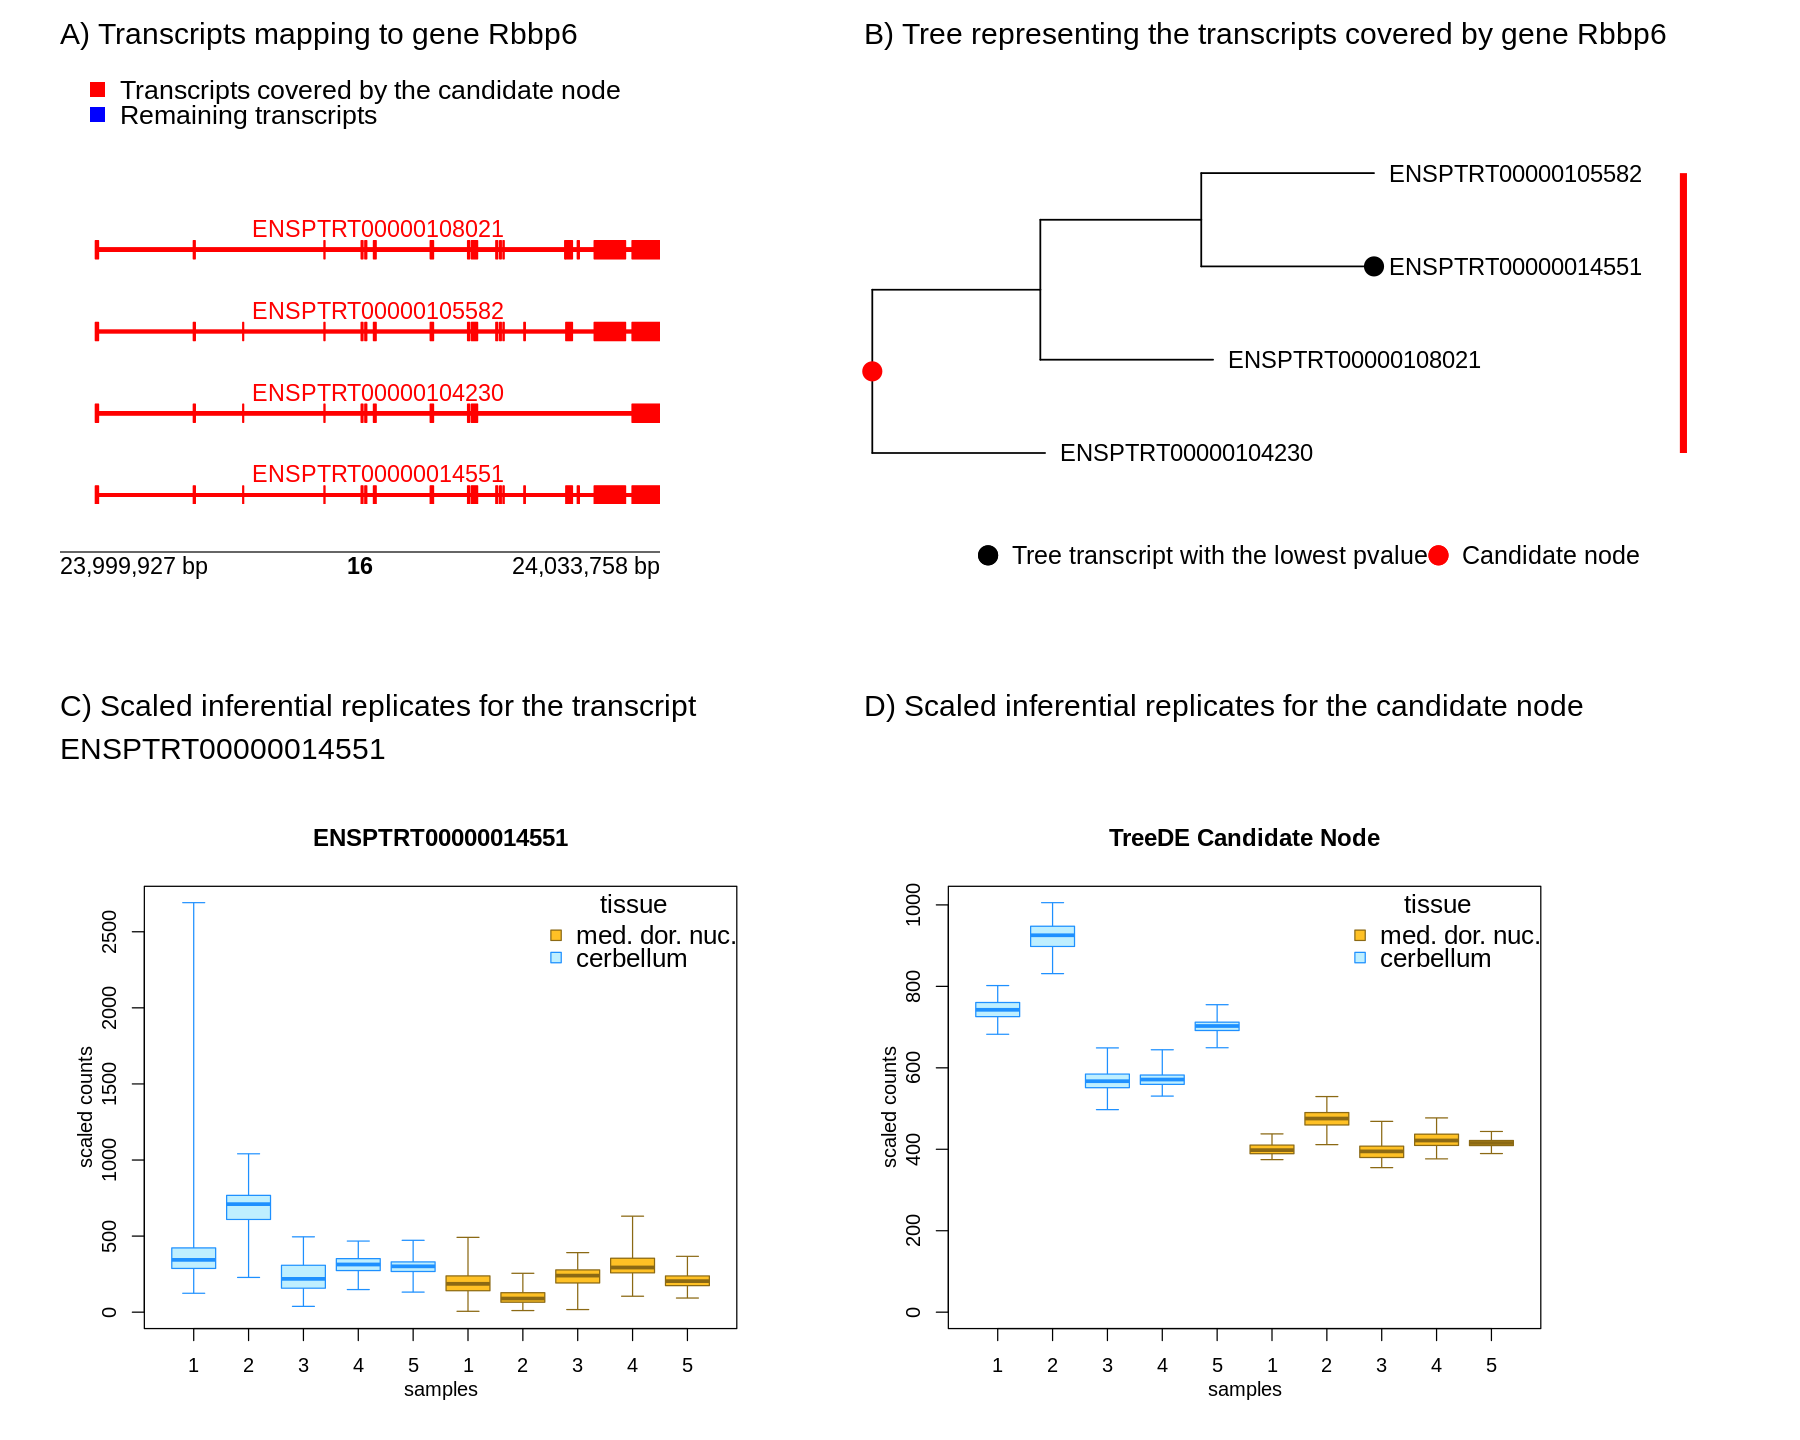

In [294]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), "ENSPTRT00000080361"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Rbbp6", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.2, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.6, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Rbbp6", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 0.9, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [295]:
j <- 67
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000091292" "ENSPTRT00000026544"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000014209"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
22,15314313,15330622,16310,+,ENSPTRG00000014209


ENSPTRG00000014209   ENSPTRG00000014209   ENSPTRG00000014209 
"ENSPTRT00000026544" "ENSPTRT00000091292" "ENSPTRT00000103825"

[1] 2

[1] TRUE

In [297]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 5
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



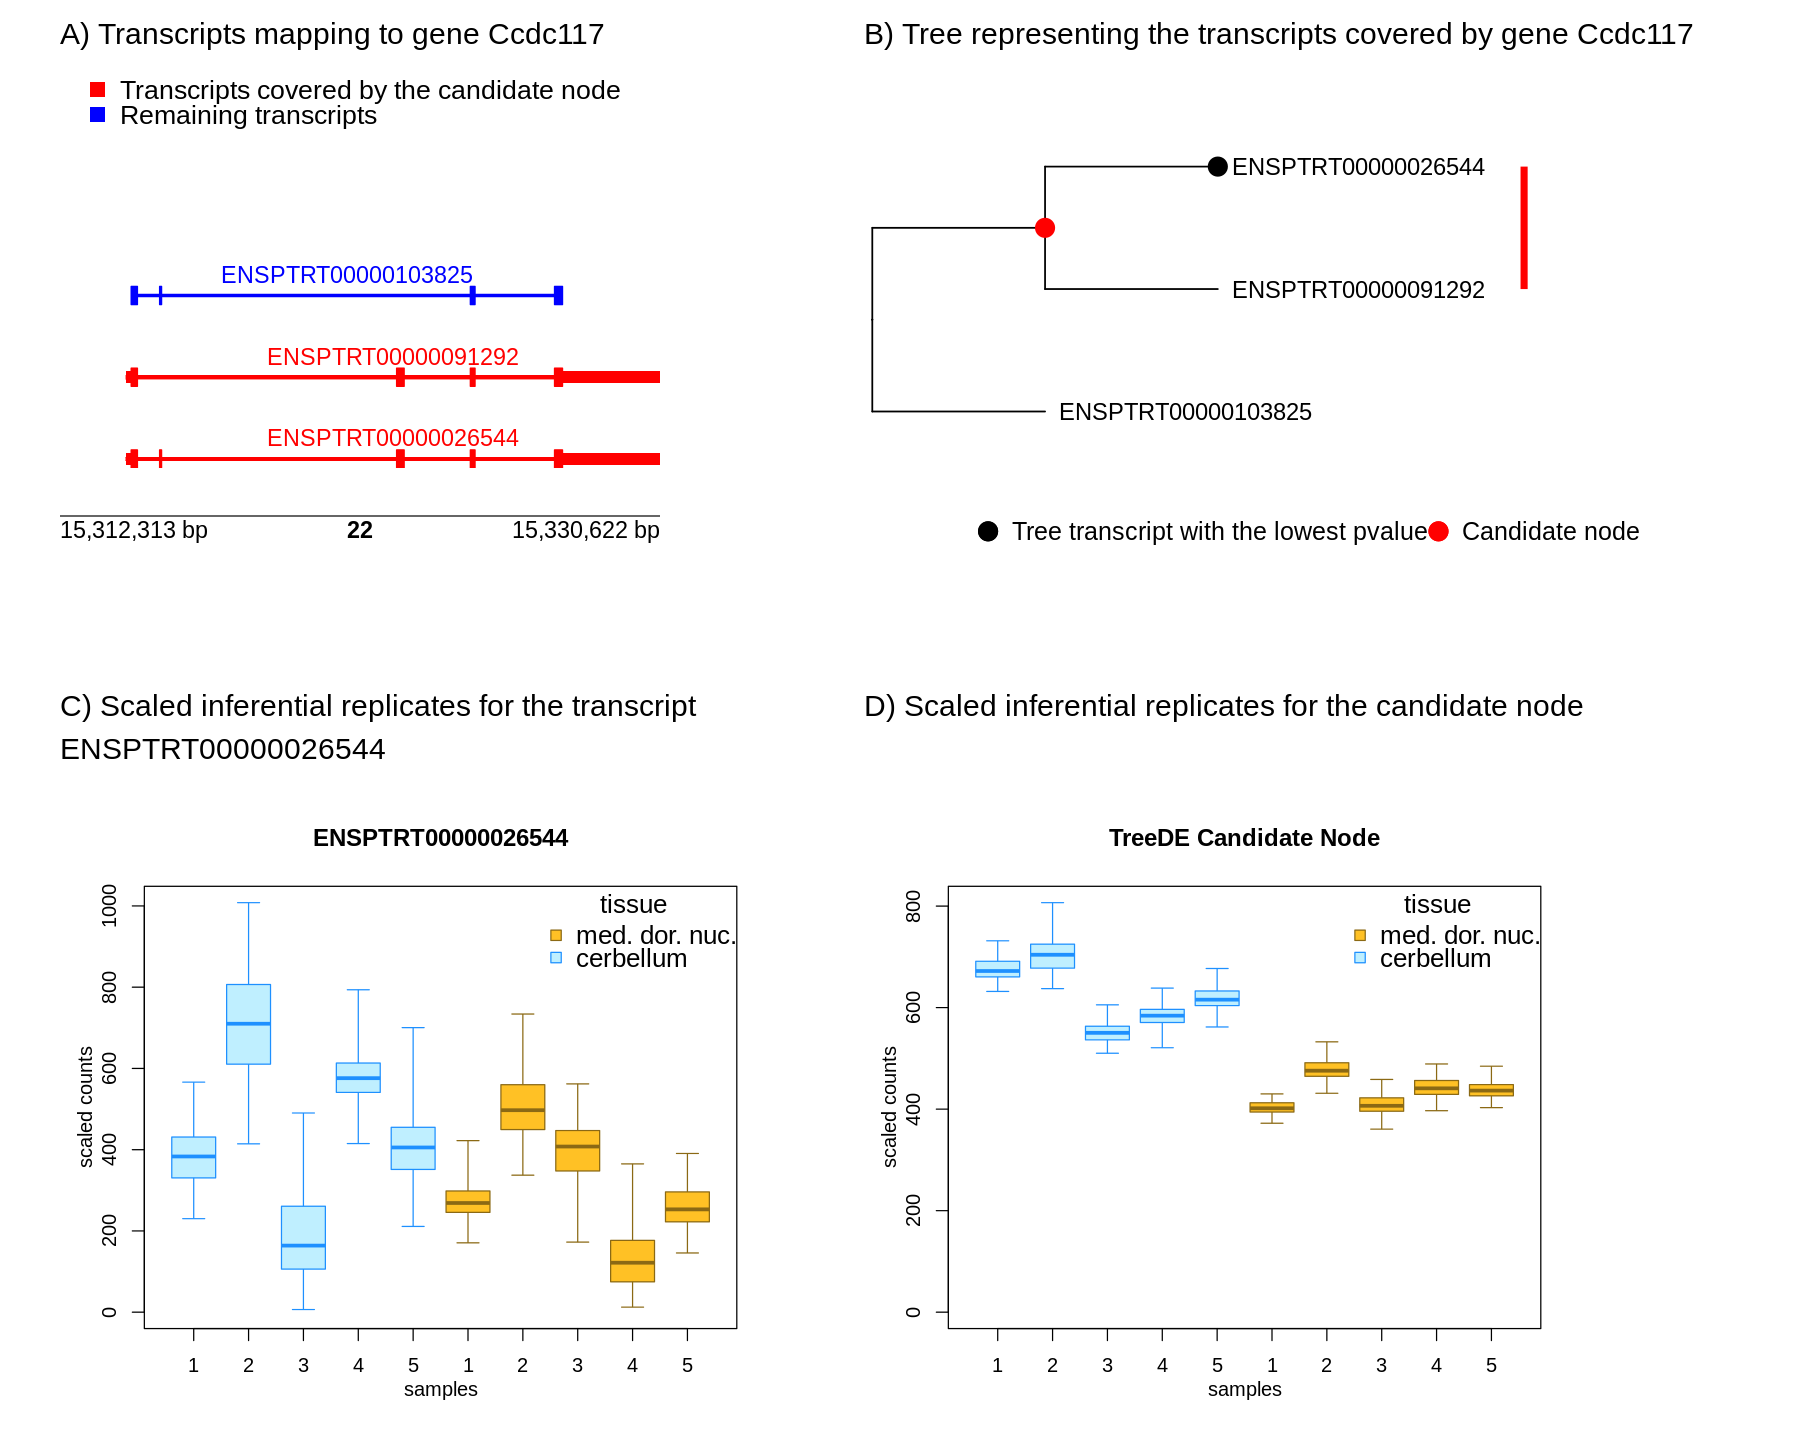

In [300]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), "ENSPTRT00000080361"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Ccdc117", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 3.9, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.3, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Ccdc117", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 0.7, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [307]:
j <- 74
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000095572" "ENSPTRT00000091774" "ENSPTRT00000029738"
[4] "ENSPTRT00000106333" "ENSPTRT00000093955"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000015932"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
4,16269112,16383072,113961,-,ENSPTRG00000015932


ENSPTRG00000015932   ENSPTRG00000015932   ENSPTRG00000015932 
"ENSPTRT00000029738" "ENSPTRT00000091774" "ENSPTRT00000093955" 
  ENSPTRG00000015932   ENSPTRG00000015932 
"ENSPTRT00000095572" "ENSPTRT00000106333"

[1] 1

[1] TRUE

In [315]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 6
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



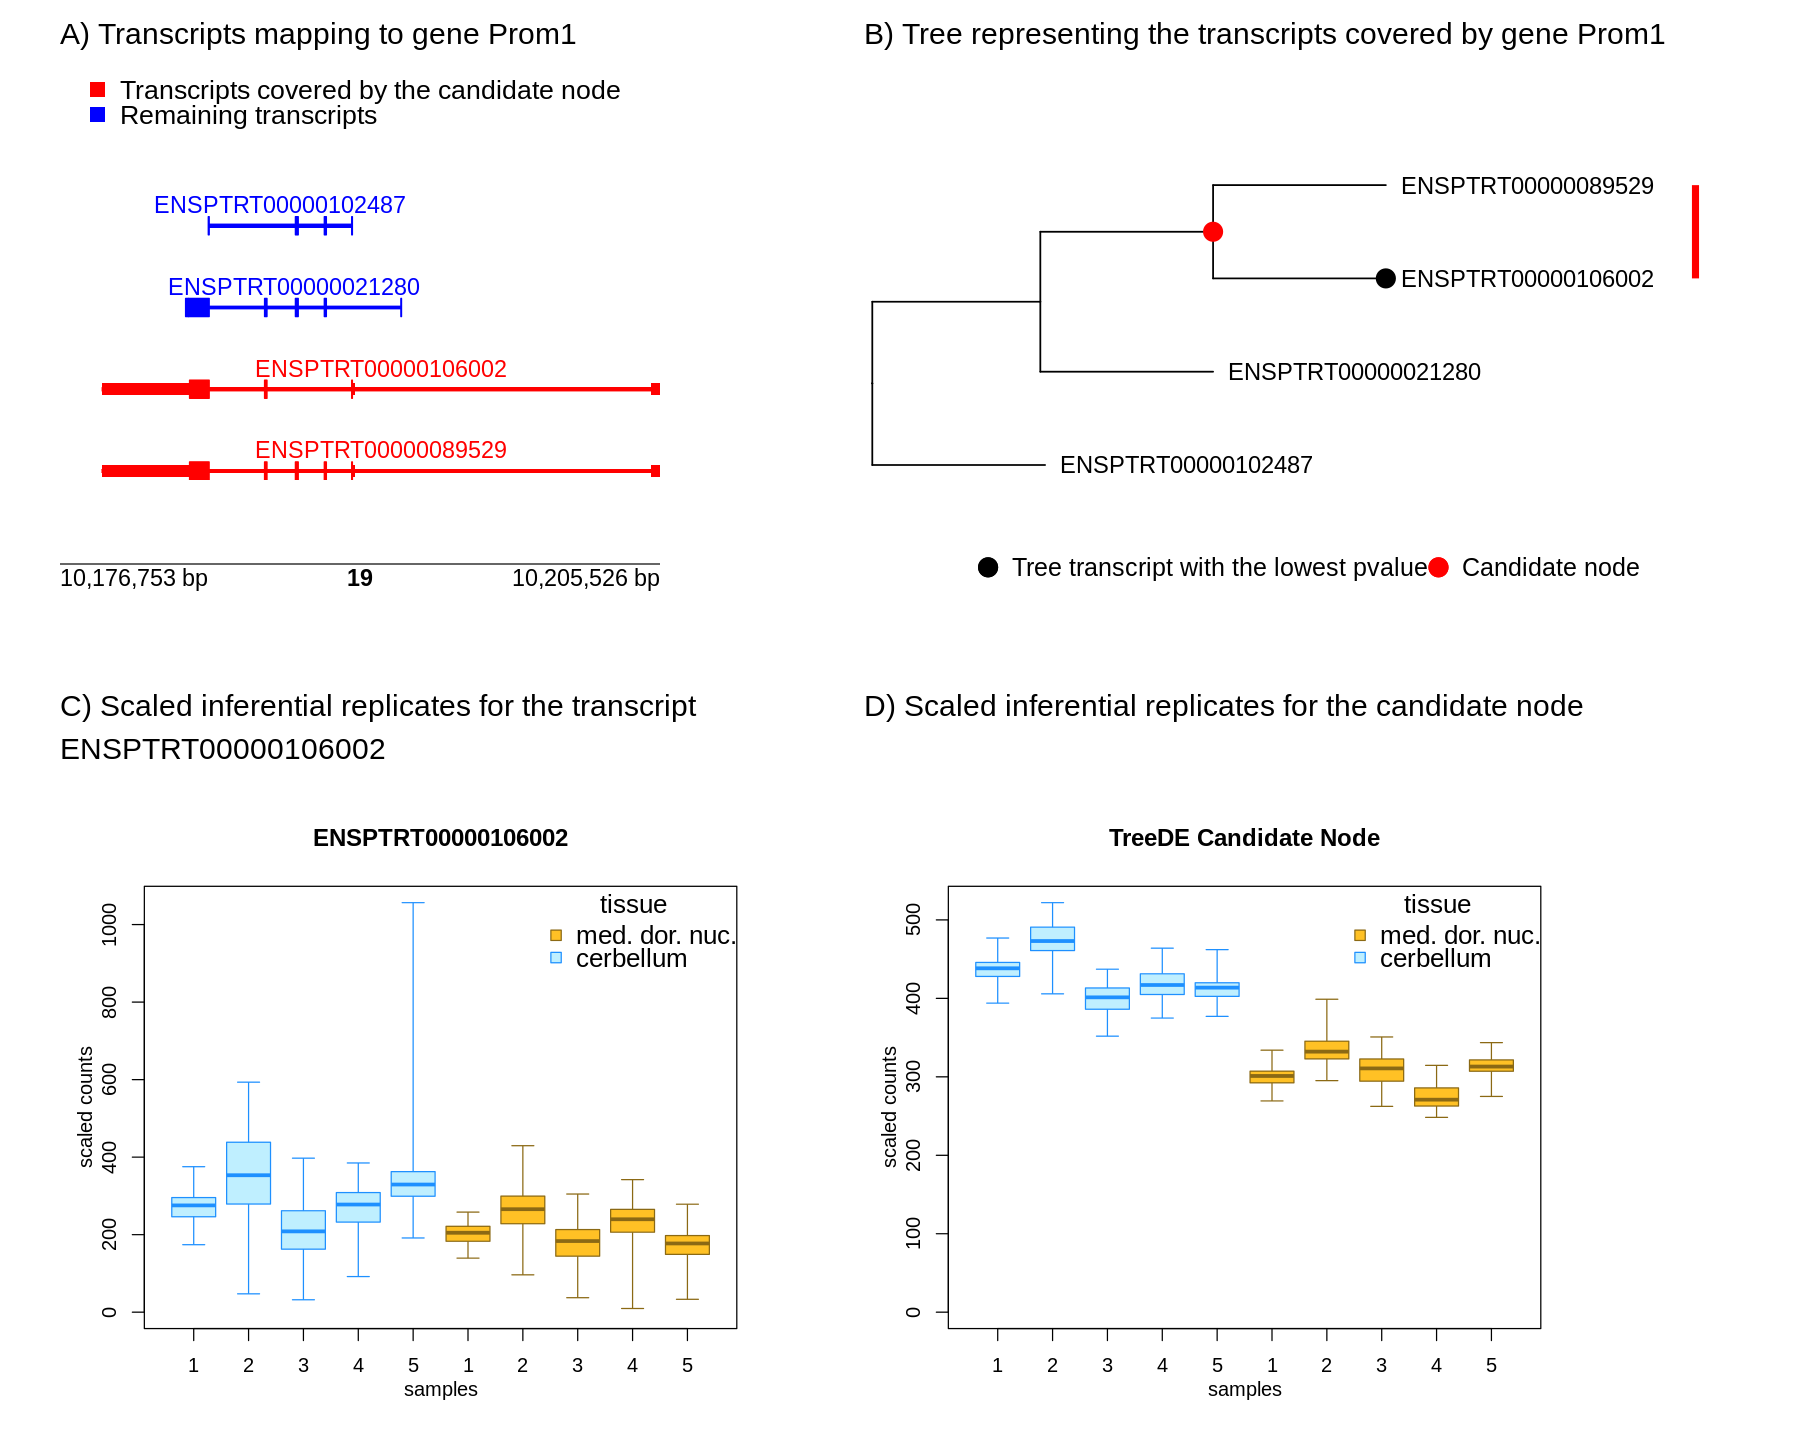

In [94]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))
                                ))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Prom1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Prom1", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [86]:
j <- 83
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000106002" "ENSPTRT00000089529"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000010449"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
19,10178753,10205526,26774,-,ENSPTRG00000010449


ENSPTRG00000010449   ENSPTRG00000010449   ENSPTRG00000010449 
"ENSPTRT00000021280" "ENSPTRT00000089529" "ENSPTRT00000102487" 
  ENSPTRG00000010449 
"ENSPTRT00000106002"

[1] 1

[1] TRUE

In [87]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 7
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



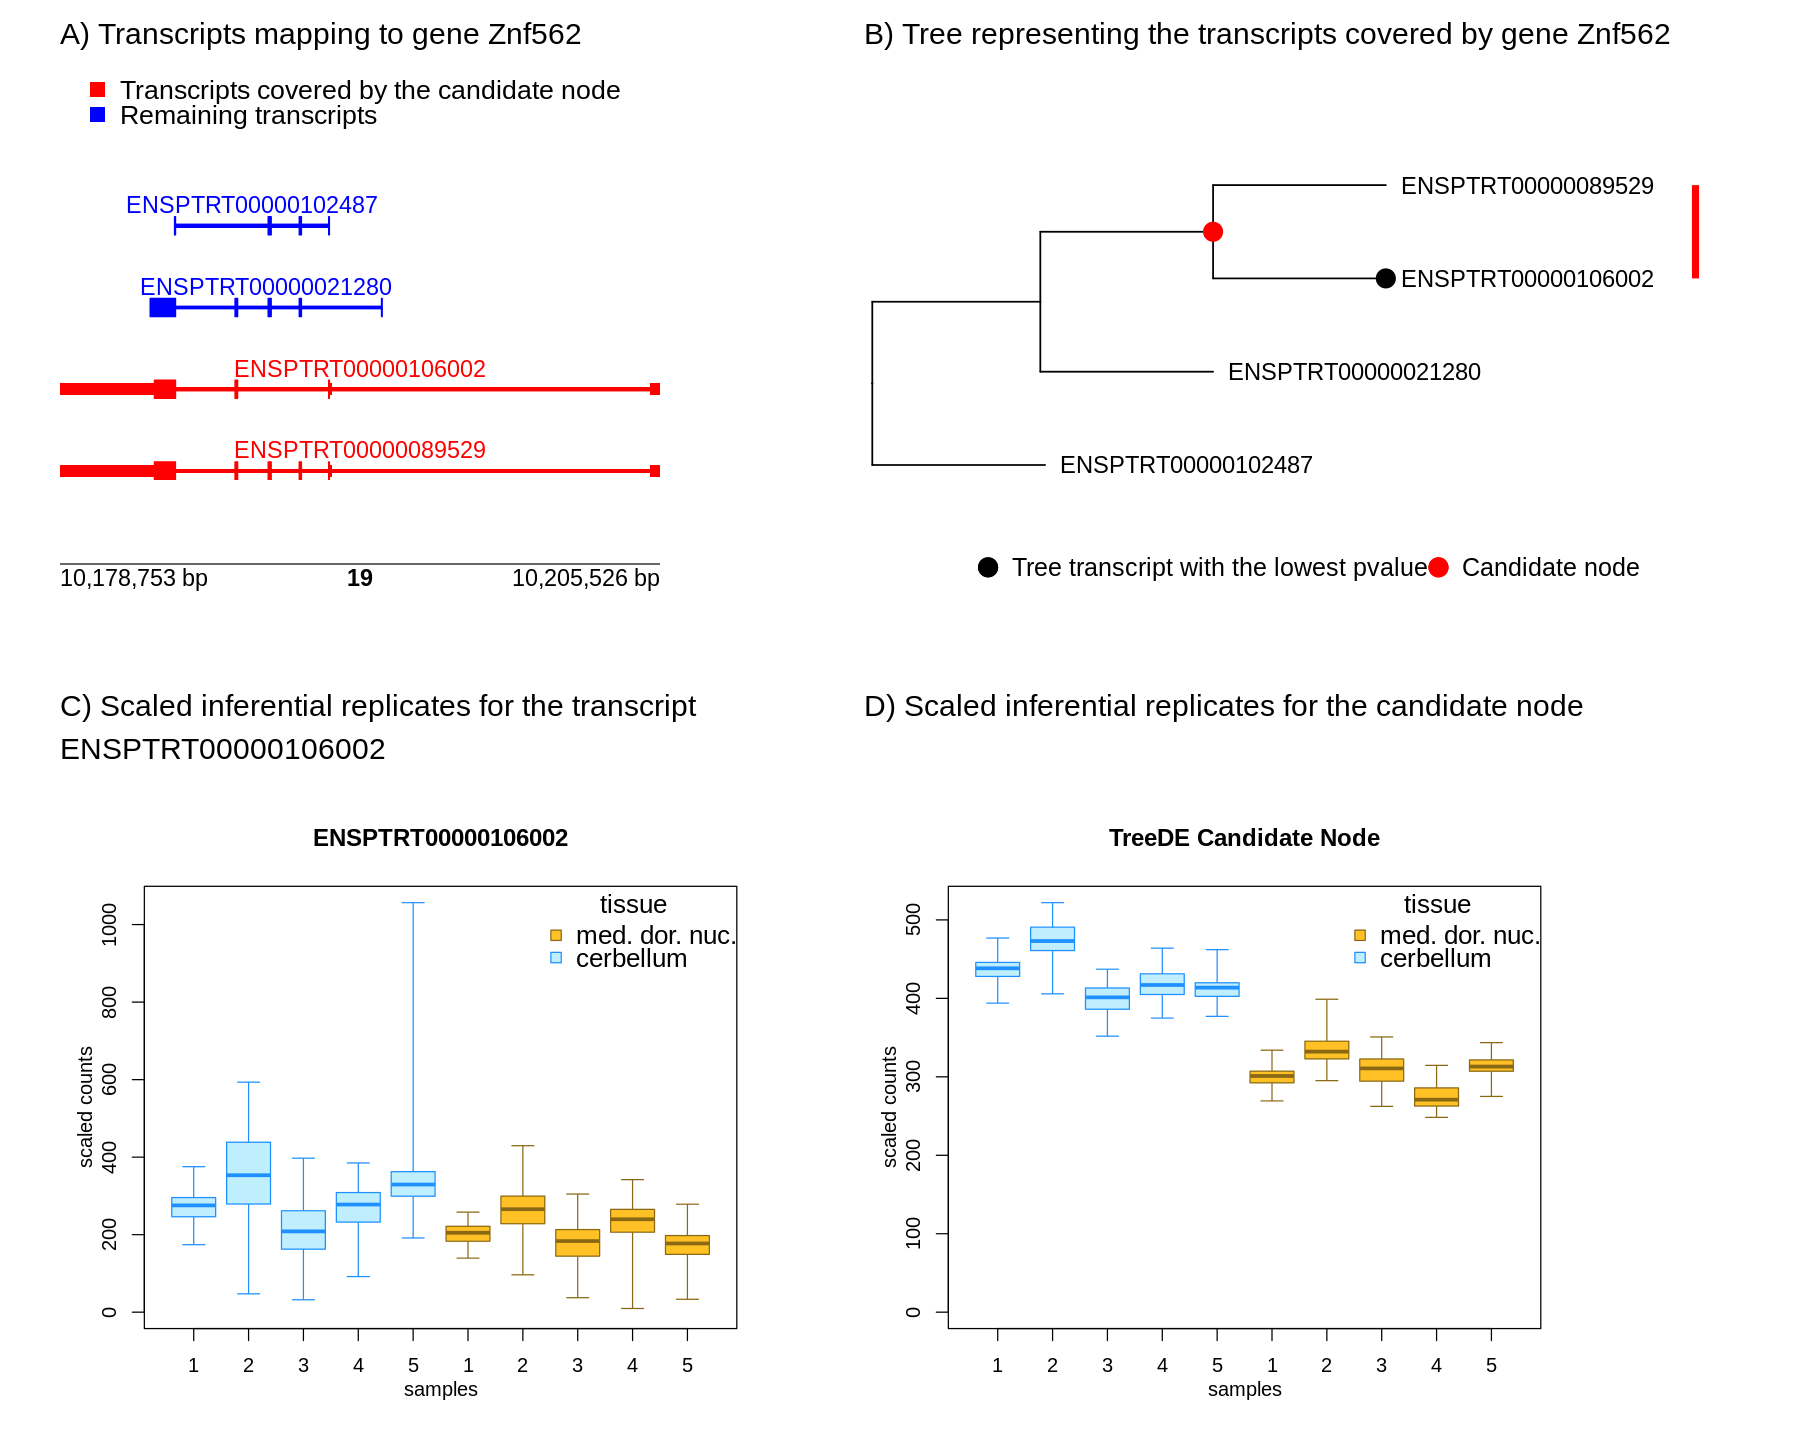

In [92]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]], chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), "ENSPTRT00000052888"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Znf562", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Znf562", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [100]:
j <- 143
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000099046" "ENSPTRT00000087333" "ENSPTRT00000107740"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000011383"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
19,53619372,53627529,8158,-,ENSPTRG00000011383


ENSPTRG00000011383   ENSPTRG00000011383   ENSPTRG00000011383 
"ENSPTRT00000021176" "ENSPTRT00000087333" "ENSPTRT00000099046" 
  ENSPTRG00000011383 
"ENSPTRT00000107740"

[1] 1

[1] TRUE

In [103]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 6
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topleft"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topleft"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



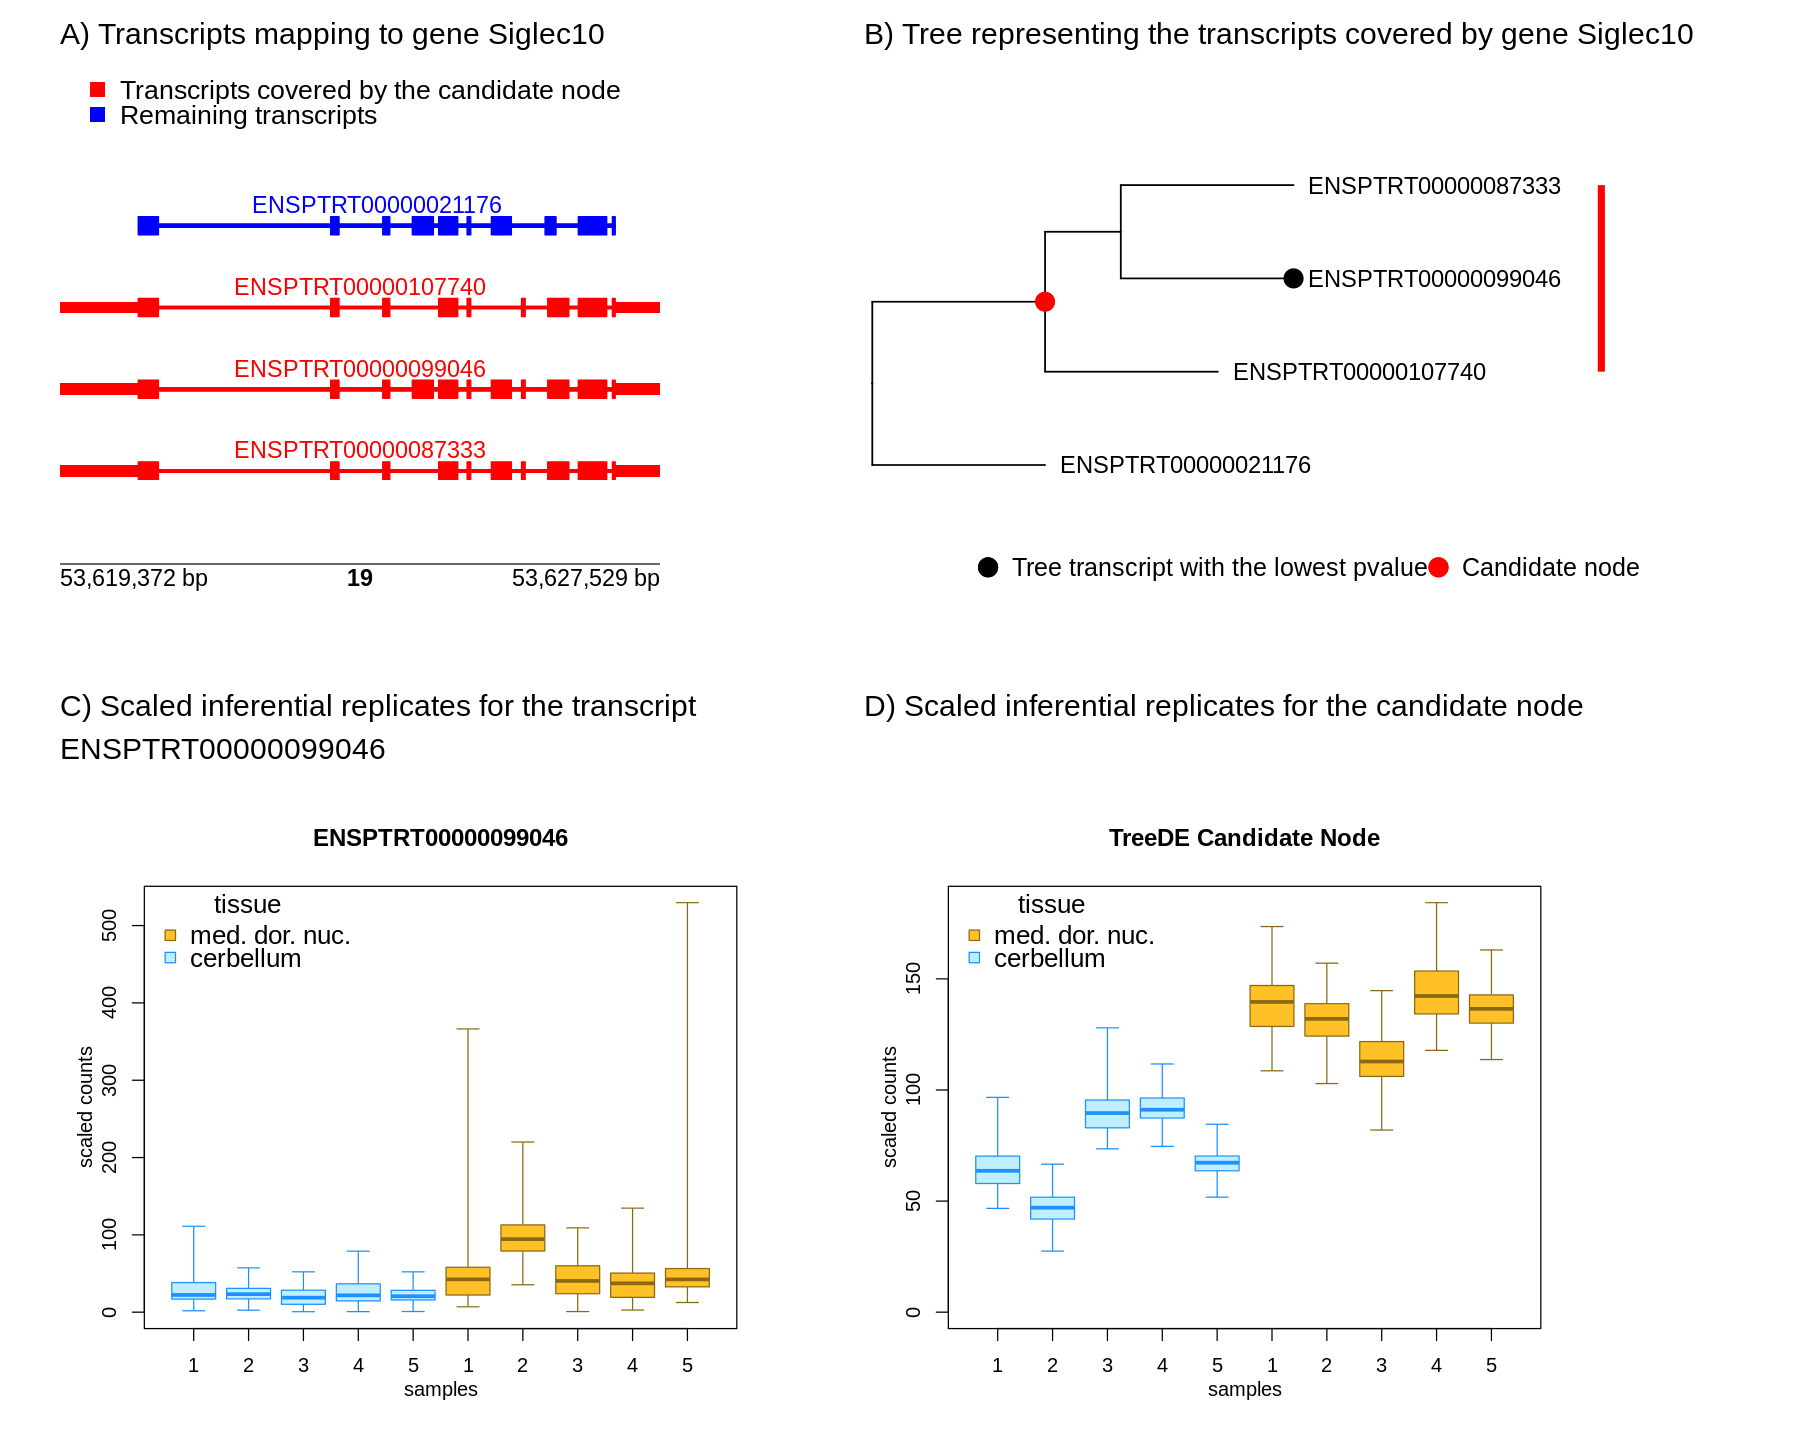

In [105]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]], chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), "ENSPTRT00000052888"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Siglec10", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Siglec10", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [145]:
j <- 194
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000028090" "ENSPTRT00000099623" "ENSPTRT00000085092"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000015004"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
3,53637898,53652324,14427,-,ENSPTRG00000015004


ENSPTRG00000015004   ENSPTRG00000015004   ENSPTRG00000015004 
"ENSPTRT00000028090" "ENSPTRT00000077179" "ENSPTRT00000085092" 
  ENSPTRG00000015004 
"ENSPTRT00000099623"

[1] 1

[1] TRUE

In [146]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 6
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topleft"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomleft"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



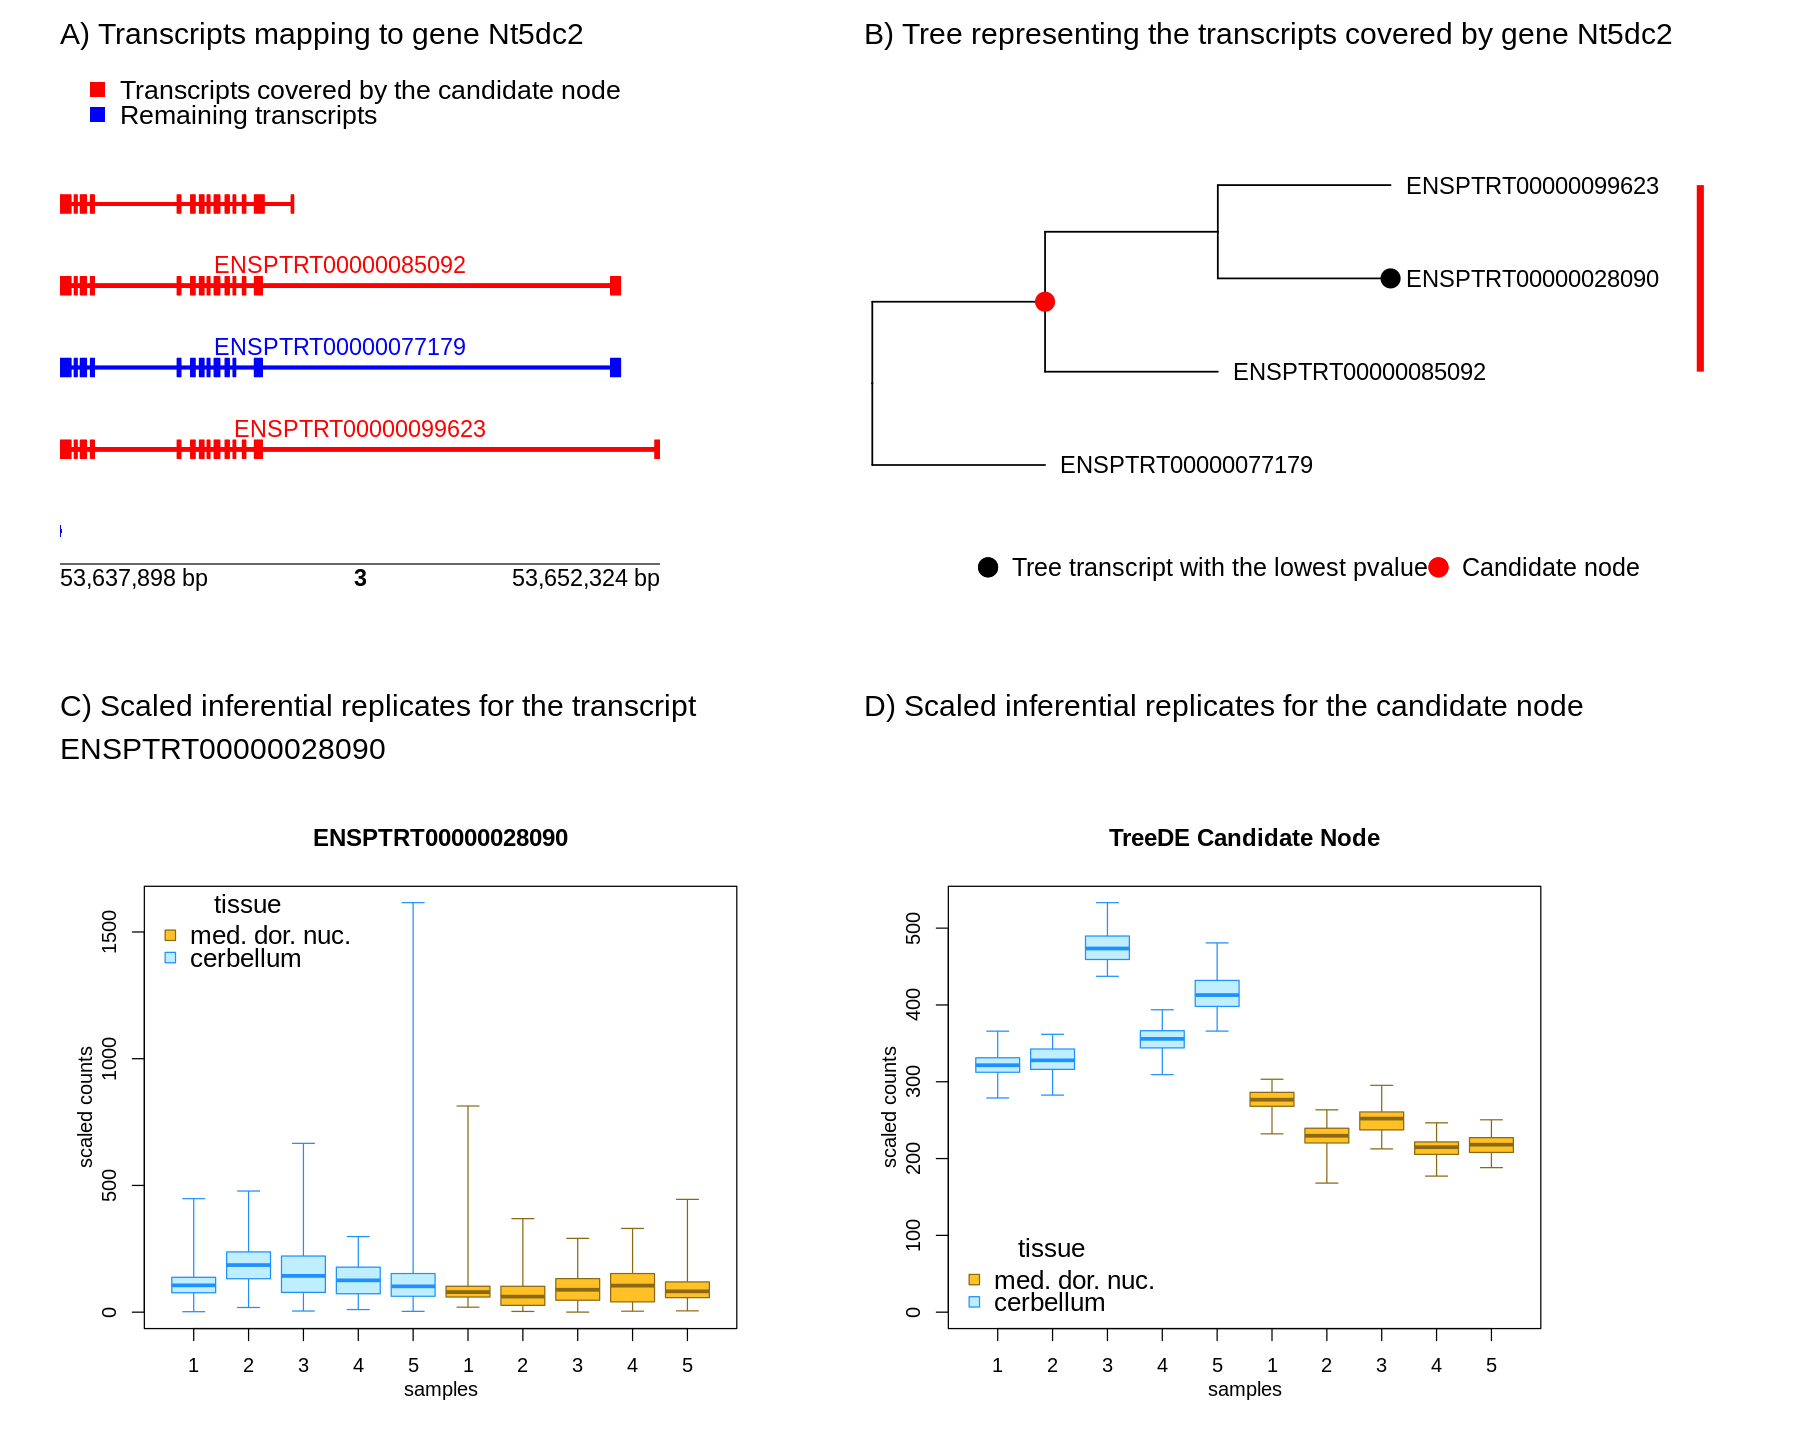

In [147]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]], chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), "ENSPTRT00000052888"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Nt5dc2", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.5, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Nt5dc2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [175]:
j <- 148
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000003061" "ENSPTRT00000003062"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000001689"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
1,150898339,150979162,80824,+,ENSPTRG00000001689


ENSPTRG00000001689   ENSPTRG00000001689   ENSPTRG00000001689 
"ENSPTRT00000003061" "ENSPTRT00000003062" "ENSPTRT00000079823"

[1] 2

[1] TRUE

In [176]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 4
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topleft"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomleft"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



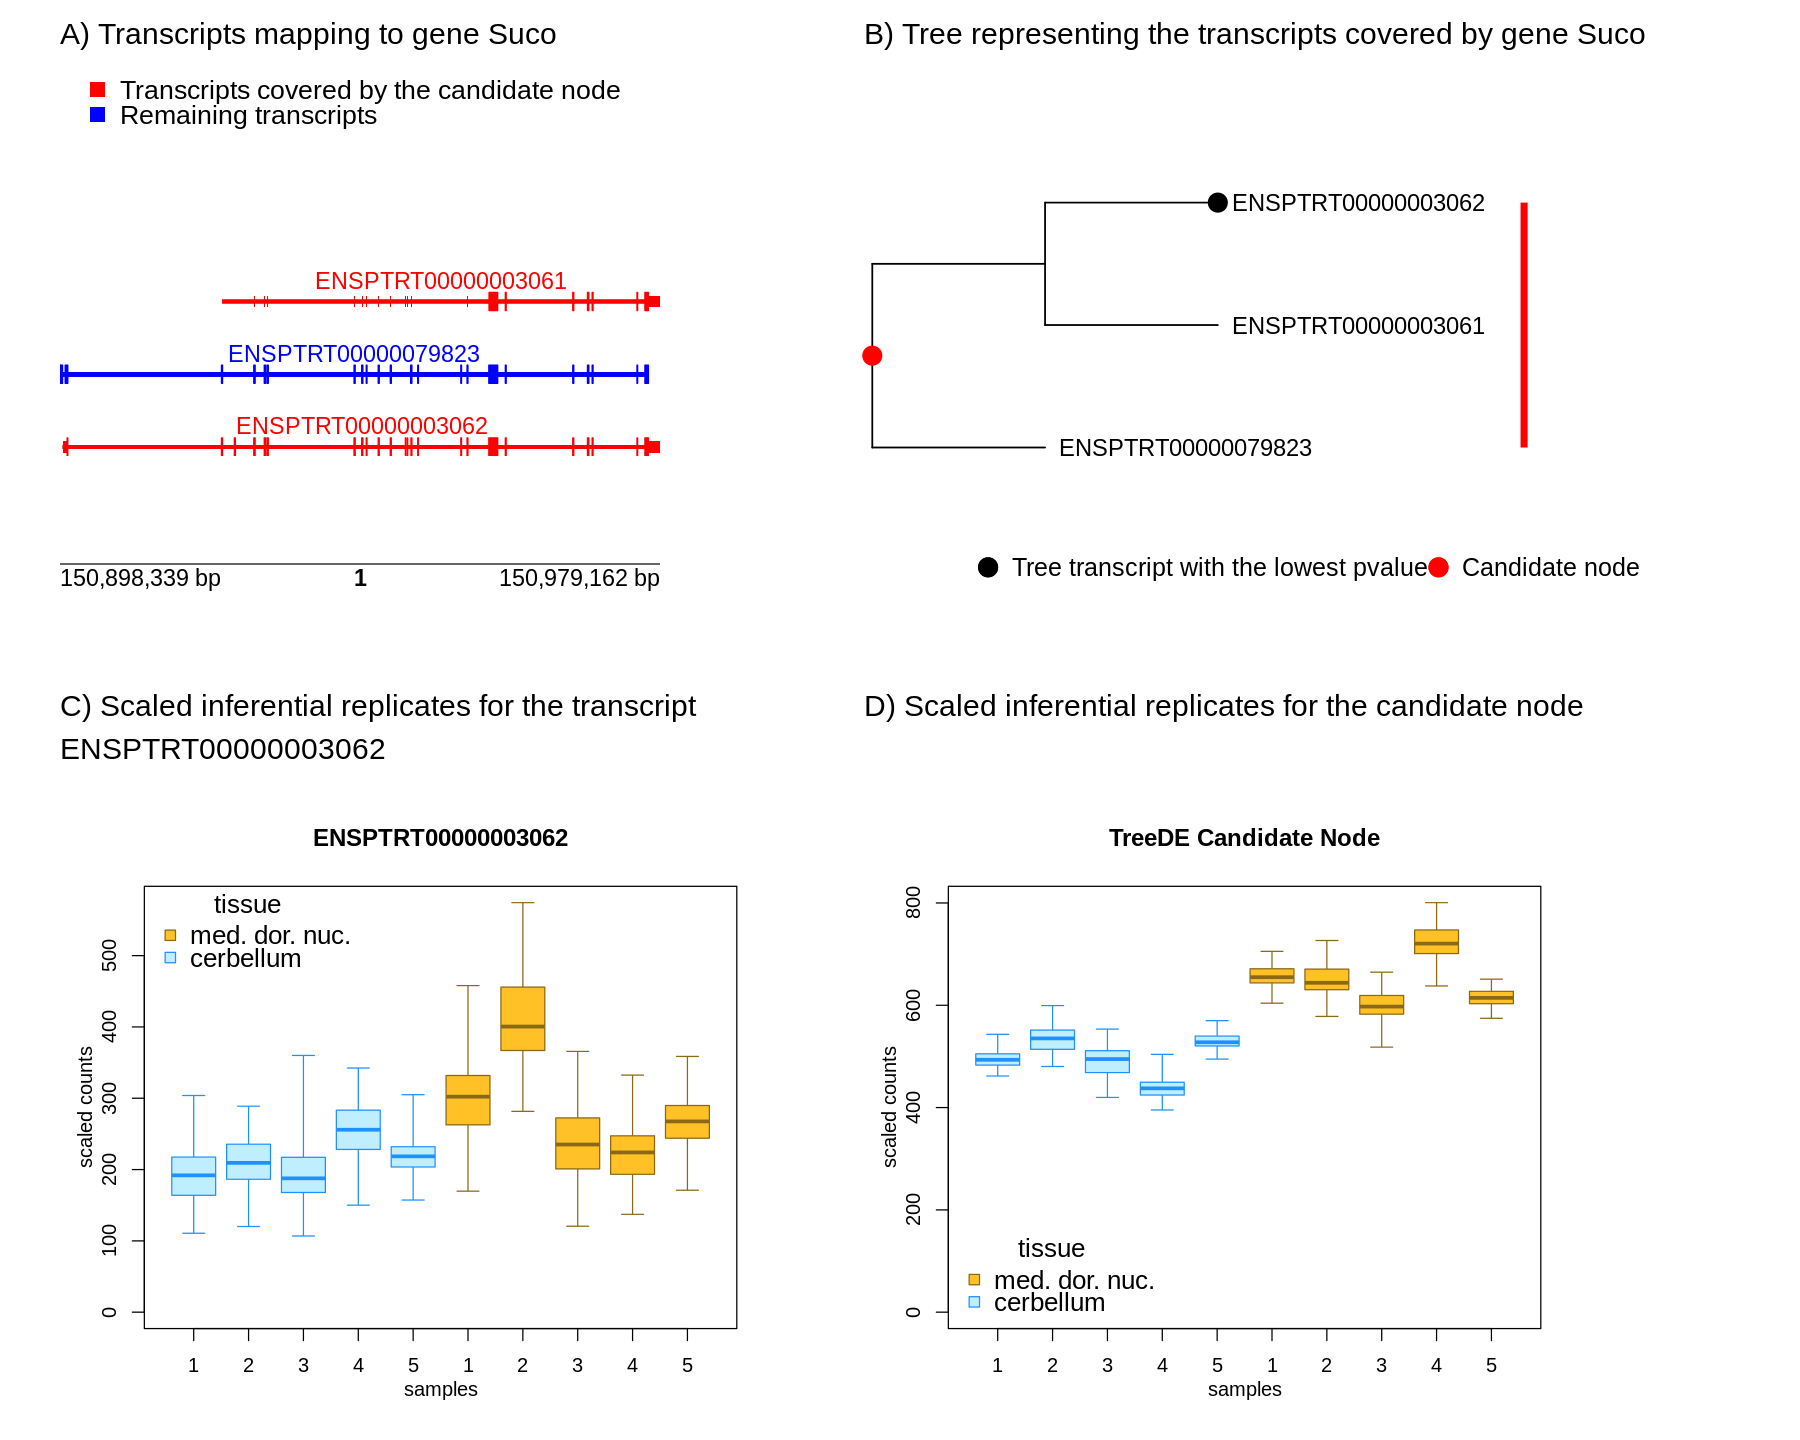

In [181]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]], chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))
                                ))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Suco", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 3.8, width = 5, height = 5.5, 
    spaceHeight=2, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Suco", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [183]:
j <- 47
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSPTRT00000050204" "ENSPTRT00000097837" "ENSPTRT00000081427"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000020873"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
9,34925532,35001538,76007,+,ENSPTRG00000020873


ENSPTRG00000020873   ENSPTRG00000020873   ENSPTRG00000020873 
"ENSPTRT00000050204" "ENSPTRT00000081427" "ENSPTRT00000097837" 
  ENSPTRG00000020873 
"ENSPTRT00000111009"

[1] 1

[1] TRUE

In [190]:
options(repr.plot.width=14, repr.plot.height=9)
of=126.5
inNode <- 6
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 360) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "tissue", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "bottomleft"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "tissue", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "bottomleft"))

legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



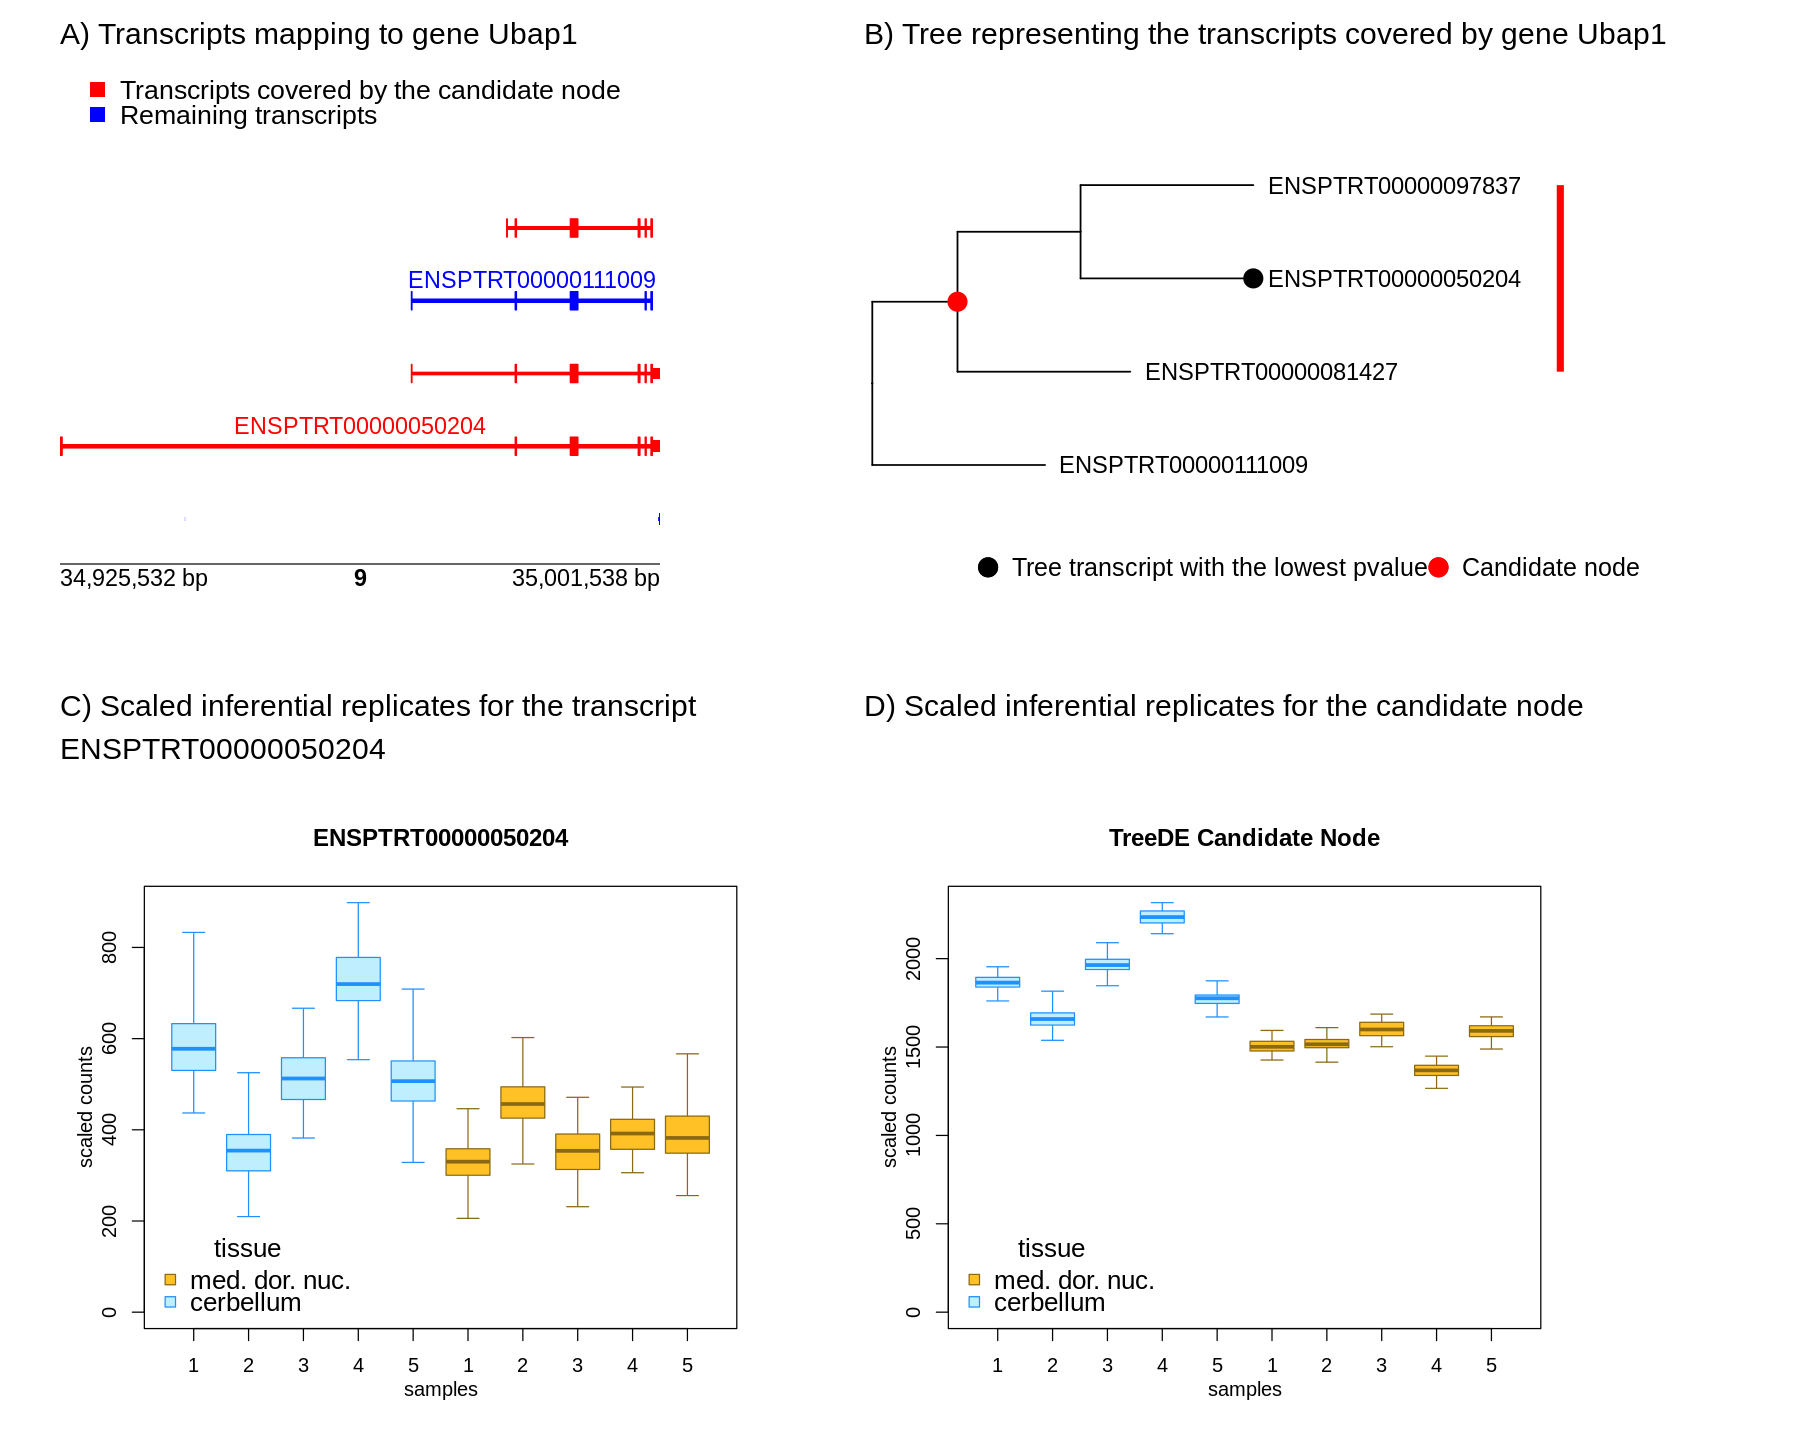

In [192]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]], chromend = g[["end"]],
  assembly = assemb, just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show), 
                                  "ENSPTRT00000071023"), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show))),
                                "white"))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Ubap1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.4, width = 5, height = 5.5, 
    spaceHeight=2, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Ubap1", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label=paste("C) Scaled inferential replicates for the transcript \n", txp_min, sep=""), 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [197]:
j <- 56
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- gsub("\\.+\\d+","",rownames(tseChimp)[Descendants(treeCons,iNode)[[1]]])
tx_to_show

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unique(unlist(mapDf[treeSub$tip, "GENEID"]))
treeSub$tip.label <- gsub("\\.+\\d+", "", treeSub$tip.label)
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% gsub("\\.+\\d+", "", treeCons$tip.label))

unique(gs)
g <- genesChimp %>% 
    filter(gene_id == gs[1]) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show
mcols(y)[gTxps,]
mcols(yAll)[iNode,]

[1] "ENSPTRT00000059341" "ENSPTRT00000081251" "ENSPTRT00000080057"
[4] "ENSPTRT00000101507"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSPTRG00000013164"

seqnames,start,end,width,strand,gene_id
<fct>,<int>,<int>,<int>,<fct>,<chr>
20,1343414,1369108,25695,-,ENSPTRG00000013164


ENSPTRG00000013164   ENSPTRG00000013164   ENSPTRG00000013164 
"ENSPTRT00000059341" "ENSPTRT00000079289" "ENSPTRT00000080057" 
  ENSPTRG00000013164   ENSPTRG00000013164   ENSPTRG00000013164 
"ENSPTRT00000081251" "ENSPTRT00000091581" "ENSPTRT00000101507"

[1] 5

[1] TRUE

DataFrame with 6 rows and 10 columns
                               TXNAME             GENEID log10mean      keep
                          <character>        <character> <numeric> <logical>
ENSPTRT00000059341 ENSPTRT00000059341 ENSPTRG00000013164  3.034188      TRUE
ENSPTRT00000079289 ENSPTRT00000079289 ENSPTRG00000013164  0.546729     FALSE
ENSPTRT00000080057 ENSPTRT00000080057 ENSPTRG00000013164  1.214385     FALSE
ENSPTRT00000081251 ENSPTRT00000081251 ENSPTRG00000013164  0.890355     FALSE
ENSPTRT00000091581 ENSPTRT00000091581 ENSPTRG00000013164  0.880421     FALSE
ENSPTRT00000101507 ENSPTRT00000101507 ENSPTRG00000013164  2.691943      TRUE
                        stat    log2FC    pvalue    locfdr    qvalue meanInfRV
                   <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
ENSPTRT00000059341       1.6 0.0257536 0.7087736  1.000000  0.796873  0.451108
ENSPTRT00000079289        NA        NA        NA        NA        NA  0.308557
ENSPTRT00000080057        NA   

DataFrame with 1 row and 10 columns
               TXNAME      GENEID log10mean      keep      stat    log2FC
          <character> <character> <numeric> <logical> <numeric> <numeric>
Node50491   Node50491           4   3.20306      TRUE      9.78  0.126111
             pvalue    locfdr    qvalue meanInfRV
          <numeric> <numeric> <numeric> <numeric>
Node50491 0.0203353  0.264801 0.0447456  0.070077